# AI534 Implementation Assignment 2###

**Deadline**: Sunday, Oct. 29, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance as well based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for noisy training). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Mounted at /content/gdrive


You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [ ]:
# your code goes here
train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)
noisy_train=pd.read_csv(noisy_train_path)

In [ ]:
processed_train_data = train_data.copy()
processed_val_data   = val_data.copy()
processed_noisy_train   = noisy_train.copy()

normalized=["Age", "Annual_Premium", "Vintage"]

mean_values          = processed_train_data[normalized].mean()
std_deviation_values = processed_train_data[normalized].std()

# Apply z-score normalization
processed_train_data[normalized] = (processed_train_data[normalized] - mean_values) / std_deviation_values
processed_val_data[normalized] = (processed_val_data[normalized] - mean_values) / std_deviation_values
processed_noisy_train[normalized] = (processed_noisy_train[normalized] - mean_values) / std_deviation_values

#should speedup training without impacting quality too much
processed_train_data = processed_train_data.astype('float32')
processed_val_data = processed_val_data.astype('float32')
processed_noisy_train = processed_noisy_train.astype('float32')

print(processed_train_data.dtypes)

dummy                       float32
Gender                      float32
Age                         float32
Driving_License             float32
Previously_Insured          float32
                             ...   
Policy_Sales_Channel_158    float32
Policy_Sales_Channel_159    float32
Policy_Sales_Channel_160    float32
Policy_Sales_Channel_163    float32
Response                    float32
Length: 198, dtype: object


# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information).


## Impelement Logistic regression with L2 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression_with_l2(X, y, lambda_reg, learning_rate, max_iterations, threshold):
    m, n = X.shape           # m is the total number of training examples, n is the number of features
    w = np.zeros(n)          # Initializing weights to zero
    losses = []

    for iteration in tqdm(range(max_iterations)):
        #make predictions
        z = np.dot(X, w)
        y_pred = sigmoid(z)

        gradient = (1 / m) * np.dot(X.T, y_pred - y) + (lambda_reg / m) * w
        #dont regularize bias
        gradient[0] -= (lambda_reg / m) * w[0]

        w -= learning_rate * gradient


        # Compute the loss
        loss = (-1 / m) * (np.dot(y, np.log(y_pred)) + np.dot(1 - y, np.log(1 - y_pred))
                          + (lambda_reg / 2) * np.sum(w[1:] ** 2))
        losses.append(loss)

        # Check for convergence
        if iteration > 0 and abs(losses[-1] - losses[-2]) < threshold:
            print(f"Converged after {iteration} iterations.")
            return w, losses

        # Check for divergence
        if iteration > 0 and losses[-1] > losses[-2]:
            print(f"Diverged after {iteration} iterations.")
            raise Exception("Divergence detected!")

    print("Reached the maximum number of iterations.")
    return w, losses

def predict(X, w):
    z = np.dot(X, w)
    y_pred = sigmoid(z)
    predictions = (y_pred >= 0.5).astype(int)
    return predictions

100%|██████████| 5000/5000 [00:19<00:00, 258.54it/s]


Reached the maximum number of iterations.
Trained Weights: [-8.30366146e-02  6.14677714e-03  1.05650996e-01 -8.04697082e-02
 -4.95747525e-01  4.46697510e-01  5.29119229e-02 -3.28022689e-02
 -3.05171451e-03 -8.05978358e-04  3.19523963e-04  7.71845696e-03
  2.04741250e-03  1.10839427e-03 -8.12602511e-03 -1.63824343e-03
 -2.19173283e-02 -4.77126141e-03 -3.75338324e-03 -5.40550785e-03
 -8.88889148e-04 -5.77348769e-04  1.26330701e-03 -1.58486599e-02
 -1.39036318e-03 -4.51246674e-03  8.24910906e-04  3.36352591e-03
 -1.93530132e-03 -6.07622944e-03 -3.48659726e-03  2.15173014e-03
  2.33269495e-03 -5.24576835e-03 -1.43534886e-03 -2.75419057e-03
  8.90155512e-02 -5.93869944e-03 -1.40771595e-02 -5.96887984e-04
 -3.57424133e-03 -9.99084623e-03  3.16566308e-03  3.14571466e-03
 -8.93238515e-03 -8.49897359e-03  4.41693546e-03  4.30781013e-03
 -2.82058165e-04 -1.27427047e-03  3.64076813e-04  2.22016927e-04
 -1.07012717e-03 -4.33552252e-03 -1.75475617e-02 -6.59602227e-03
 -7.77203901e-03 -1.74680711e-0

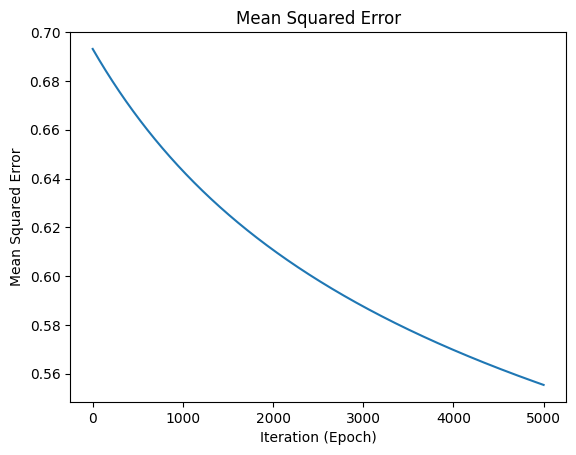

In [ ]:
# Your code goes here
cols = [col for col in processed_train_data.columns if col != 'Response']

X_train      = processed_train_data[cols].values
X_validation = processed_val_data[cols].values
X_noisy      = processed_noisy_train[cols].values

#target vectors
Y_train      = processed_train_data['Response'].values
Y_validation = processed_val_data['Response'].values
Y_noisy      = processed_noisy_train['Response'].values

w,losses=logistic_regression_with_l2(X_train,Y_train,1e-3,1e-3,5000,1e-7)     # Training logistic regression model

print("Trained Weights:", w)

plt.plot(losses)
plt.title("Mean Squared Error")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Mean Squared Error")
plt.show()

##Experiment with different regularization parameters
For this part, you will need to run your L2 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required. Feel free to experiment with more extreme or in-between values to help you answer the questions.

**Learning Rate Tuning Guidelines:**
For different values of $\lambda$, you'll need varying learning rates. I recommend starting with $\gamma = 1$ for very small $\lambda$s like $10^{-5}, 10^{-4}$. For larger $\lambda$ values like $10^{-3}$, consider a smaller learning rate like $\gamma = 0.1$. You will need to further reduce the learning rate as $\lambda$ gets bigger.

For each $\lambda$ value, you are required to run the logistic regression to convergence, record the resulting model (the weight vector), evaluate it on the training and validation data and record the accuracies.

In [ ]:
l_curve = {}                                           # Store MSE loss for different learning rate
weights   = {}                                         # Store weight learned for different learning rate

for lambda_reg in [10**i for i in range(-5, 1)]:
  # set different learning rate for different range of lambda value
  if lambda_reg <= 1e-4:
    learning_rate = 1.0
  elif lambda_reg <= 1e-3:
    learning_rate = 0.11
  else:
    learning_rate = 0.01

  w,l=logistic_regression_with_l2(X_train,Y_train,lambda_reg,learning_rate,50000,1e-7)
  l_curve[str(lambda_reg)] = l                          # store sequence of T MSE in dictionary
  weights[str(lambda_reg)]   = w                        # store trained weight in dictionary

 18%|█▊        | 8877/50000 [00:33<02:35, 263.96it/s]


Converged after 8877 iterations.


 18%|█▊        | 8878/50000 [00:31<02:26, 280.84it/s]


Converged after 8878 iterations.


 36%|███▋      | 18156/50000 [01:05<01:54, 279.15it/s]


Converged after 18156 iterations.


 78%|███████▊  | 39147/50000 [02:32<00:42, 256.41it/s]


Converged after 39147 iterations.


 79%|███████▉  | 39450/50000 [02:24<00:38, 272.10it/s]


Converged after 39450 iterations.


 84%|████████▍ | 42012/50000 [02:30<00:28, 278.61it/s]

Converged after 42012 iterations.


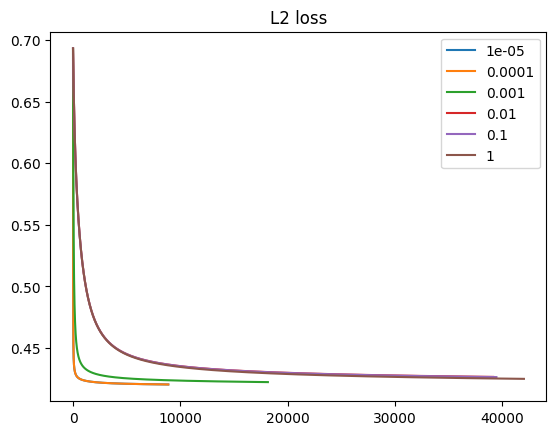

In [ ]:
for i in l_curve:
  y = l_curve[i]
  x = range(len(y))
  plt.plot(x, y, label=f'{i}')
  plt.title(f'L2 loss')
plt.legend(loc="upper right")
plt.show()

## Calculate training and validation accuracy

In [ ]:
train_accuracies = []
val_accuracies = []

lambda_values = [10**i for i in range(-5, 1)]
for lmd in lambda_values:
    w = weights[str(lmd)]

    # Evaluate the model on the training data
    y_train_pred = predict(X_train, w)
    train_accuracy = accuracy_score(Y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on the validation data
    y_val_pred = predict(X_validation, w)
    val_accuracy = accuracy_score(Y_validation, y_val_pred)
    val_accuracies.append(val_accuracy)
    print(f"Lambda: {lmd}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

Lambda: 1e-05, Train Accuracy: 0.8021666666666667, Validation Accuracy: 0.7912
Lambda: 0.0001, Train Accuracy: 0.8021666666666667, Validation Accuracy: 0.7912
Lambda: 0.001, Train Accuracy: 0.8008333333333333, Validation Accuracy: 0.7929
Lambda: 0.01, Train Accuracy: 0.7968333333333333, Validation Accuracy: 0.7932
Lambda: 0.1, Train Accuracy: 0.7968333333333333, Validation Accuracy: 0.7932
Lambda: 1, Train Accuracy: 0.7968333333333333, Validation Accuracy: 0.7938


### 1.1 Impact on training and validation accuracy

Plot the training accuracy and validation accuracy of the learned L2 regularized logistic regression model as a function of $\lambda$.
When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as $10^{-i}$. This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.  

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

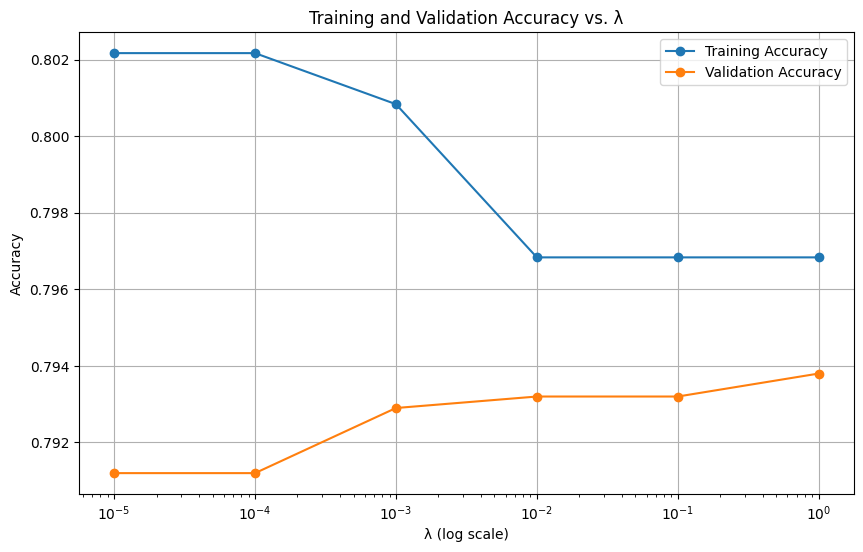

In [ ]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(lambda_values, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. λ')
plt.legend()
plt.grid(True)
plt.show()

**Question**

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.


**Your answer goes here** <br>
a. The $\lambda$ values that lead to the best training accuracy are $10^{-5}$ and $10^{-4}$, while the best validation accuracy is seen at $10^{0}$. I would choose λ equal to $10^{0}$ during deployment since it has the greatest accuracy on unseen data which is more important in production.<br>

b.  As we increase the value of $\lambda$, training accuracy gradually decreases because a higher value of $\lambda$ prevents overfitting and pushes weights to zero. But the validation accuracy increases as lambda increases for the same reason. Since the moddel is not overfit it can get more out of continued training.

###1.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [ ]:
#Your code goes here
top_features = {}

for lambda_reg in lambda_values:
    # Get the weights for the current λ sans bias
    w = weights[str(lambda_reg)][1:]                                 # select respective weight for different lambda value
    top_feature_indices = np.argsort(np.abs(w))[::-1][:5]            # selecting the top-5 highest absolute weight

    top_features[lambda_reg] = [(f"feature_{j}", w[j]) for j in top_feature_indices]

#DataFrame to display the results
df = pd.DataFrame(top_features)
df.index = ["1", "2", "3", "4", "5"]
df.columns.name = 'Rank'
df.index.name = 'λ'

#looks awful but easier to parse
#print(df)
display(df)

Rank,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000
λ,,,,,,
1,"(feature_3, -3.285838299942143)","(feature_3, -3.2858173068703724)","(feature_3, -3.2792575947373375)","(feature_3, -2.8936564233039674)","(feature_3, -2.8903348342406736)","(feature_3, -2.8491602716211952)"
2,"(feature_4, 2.2933042074441254)","(feature_4, 2.293302759547191)","(feature_4, 2.2528637878297832)","(feature_4, 2.256420223942928)","(feature_4, 2.254146326309521)","(feature_4, 2.2299817185169717)"
3,"(feature_194, -1.894181354871499)","(feature_194, -1.8941632902171432)","(feature_194, -1.9024743357792342)","(feature_194, -1.350569262277087)","(feature_194, -1.3516265038782085)","(feature_194, -1.351853012569335)"
4,"(feature_76, -1.8763724437280076)","(feature_76, -1.8763463819387418)","(feature_186, -0.9127749645197305)","(feature_186, -0.779262277988191)","(feature_186, -0.7790463317969104)","(feature_186, -0.7754680865146281)"
5,"(feature_41, 1.3818629010692636)","(feature_41, 1.3818279281194685)","(feature_10, 0.8871613775113081)","(feature_61, -0.6261304828939994)","(feature_61, -0.6247868925687845)","(feature_61, -0.612428542366623)"


**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.

**Your answer goes here**<br>
1. Yes, with higher regularization values feature "186", and "61"  become more prominent, removing features, "41", and "76" from the top 5 list.<br>

2.  Yes, with higher regularization values there seems to be a general decrease in the largest weights. Feature 3 goes from having a weight of $-3.285$ to having a weight of $-2.849$. Other features see a simmilar decrease, and with higher regularizarion values, the top 5 goes from having all 5 weights with a magnitude greater than 1 to just 3.<br>

3.  The observed differences in top features and their weights reflect the impact of L2 regularization on larger weights, pushing them to be smaller. The changes in top features suggest that regularization can shrink or amplify the impact of different features in the model.<br>

###1.3 sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here
for lambda_reg in lambda_values:
    # Get the weights for the current λ
    w = weights[str(lambda_reg)]

    # Count the number of feature weights that are approximately equal to zero
    num_zero_weights = np.sum(np.abs(w) <= 1e-6)
    print(f"λ = {lambda_reg}: Sparsity = {num_zero_weights}")



λ = 1e-05: Sparsity = 47
λ = 0.0001: Sparsity = 47
λ = 0.001: Sparsity = 47
λ = 0.01: Sparsity = 47
λ = 0.1: Sparsity = 47
λ = 1: Sparsity = 47


# **Question**

1. When we have very small $\lambda$ values, does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


**Your answer goes here**
1. Even with small $\lambda$ values, the learned model has many weights that are close to zero. This just means that they only have a small correlation with the predictions of the training data. I suspect that these may be related to one-hot encoding.

2. There seems to be no trend at $1e^{-6}$. All trained models have a sparsity of 47. Testing some other values I noticed that there is a difference at larger values, with $1e^{-4}$ showing a clear trend of models with higher regularization to be more sparse. I would expect this trend to continue with larger regularization values as there would be more of a push for smaller weights. Perhaps on datasets where such a large number of itterations is impractical a larger difference may be noticed.

# Part 2. (40 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## Impelement Logistic regression with L1 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process.
You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression_with_l1(X, y, lambda_reg, learning_rate, max_iterations, threshold):
    m, n = X.shape
    w = np.zeros(n)
    losses = []

    for iteration in tqdm(range(max_iterations)):
        z = np.dot(X, w)
        y_pred = sigmoid(z)

        # Gradient
        gradient = (1 / m) * np.dot(X.T, y_pred - y)
        gradient[1:] += (lambda_reg / m) * np.sign(w[1:])

        w -= learning_rate * gradient

        # Compute the loss
        loss = (-1 / m) * (np.dot(y, np.log(y_pred)) + np.dot(1 - y, np.log(1 - y_pred))
                          + lambda_reg * np.sum(np.abs(w[1:])))

        losses.append(loss)

        # Check for convergence
        if iteration > 0 and abs(losses[-1] - losses[-2]) < threshold:
            print(f"Converged after {iteration} iterations.")
            return w, losses

        # Check for divergence
        if iteration > 0 and losses[-1] > losses[-2]:
            print(f"Diverged after {iteration} iterations.")
            raise Exception("Divergence detected!")

    print("Reached the maximum number of iterations.")
    return w, losses

def predict(X, w):
    z = np.dot(X, w)
    y_pred = sigmoid(z)
    predictions = (y_pred >= 0.5).astype(int)
    return predictions


100%|██████████| 5000/5000 [00:18<00:00, 272.13it/s]


Reached the maximum number of iterations.
Trained Weights: [-8.30365738e-02  6.14614333e-03  1.05650918e-01 -8.04688696e-02
 -4.95747169e-01  4.46697184e-01  5.29115195e-02 -3.28017807e-02
 -3.05088463e-03 -8.05146829e-04  3.19199989e-04  7.71763499e-03
  2.04658425e-03  1.10756201e-03 -8.12521033e-03 -1.63741359e-03
 -2.19165254e-02 -4.77043639e-03 -3.75256201e-03 -5.40469026e-03
 -8.88061707e-04 -5.76525057e-04  1.26247737e-03 -1.58478543e-02
 -1.38953628e-03 -4.51163960e-03  8.24088019e-04  3.36269735e-03
 -1.93447060e-03 -6.07540916e-03 -3.48576862e-03  2.15090151e-03
  2.33187010e-03 -5.24494363e-03 -1.43451871e-03 -2.75336518e-03
  8.90150728e-02 -5.93788462e-03 -1.40763591e-02 -5.96058164e-04
 -3.57341476e-03 -9.99002653e-03  3.16483097e-03  3.14489106e-03
 -8.93157224e-03 -8.49815581e-03  4.41610930e-03  4.30698749e-03
 -2.81226768e-04 -1.27345992e-03  3.63243924e-04  2.21187262e-04
 -1.06929613e-03 -4.33470321e-03 -1.75467632e-02 -6.59520306e-03
 -7.77121475e-03 -1.74597801e-0

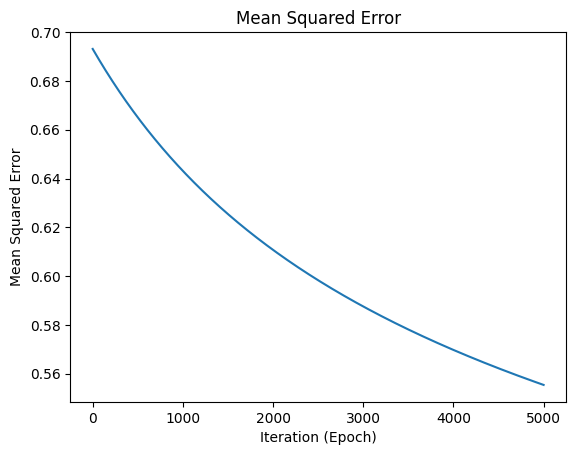

In [ ]:
# Your code goes here
cols = [col for col in processed_train_data.columns if col != 'Response']

X_train      = processed_train_data[cols].values
X_validation = processed_val_data[cols].values
X_noisy      = processed_noisy_train[cols].values

#target vectors
Y_train      = processed_train_data['Response'].values
Y_validation = processed_val_data['Response'].values
Y_noisy      = processed_noisy_train['Response'].values

w,losses     = logistic_regression_with_l1(X_train,Y_train,1e-3,1e-3, 5000, 1e-7)     # Training logistic regression model

print("Trained Weights:", w)

plt.plot(losses)
plt.title("Mean Squared Error")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Mean Squared Error")
plt.show()

##Experiment with different regularization parameters
For this part, you will need to run your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are welcome to experiment with more extreme or in-between values to help you answer the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

For each $\lambda$ value, you are required to run L1 logistic regression to convergence, record the resulting model (weights), evaluate it on the training and validation data, and record the accuracies.

 15%|█▌        | 7549/50000 [00:27<02:36, 271.20it/s]


Converged after 7549 iterations.


 15%|█▌        | 7549/50000 [00:27<02:32, 279.11it/s]


Converged after 7549 iterations.


 37%|███▋      | 18655/50000 [01:06<01:51, 281.22it/s]


Converged after 18655 iterations.


 37%|███▋      | 18668/50000 [01:06<01:51, 280.95it/s]


Converged after 18668 iterations.


 78%|███████▊  | 39177/50000 [02:25<00:40, 269.48it/s]


Converged after 39177 iterations.


 79%|███████▉  | 39697/50000 [02:25<00:37, 272.83it/s]


Converged after 39697 iterations.


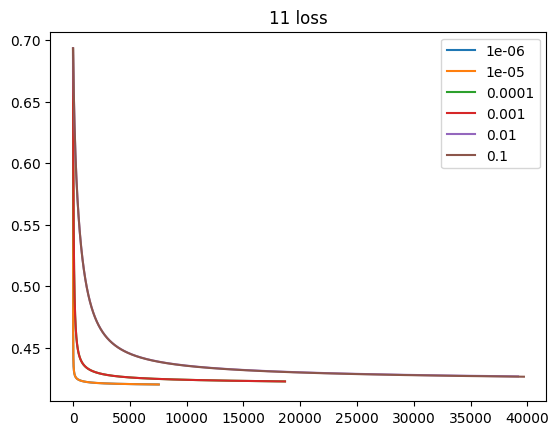

In [ ]:
# Your code goes here
cols = [col for col in processed_train_data.columns if col != 'Response']

X_train      = processed_train_data[cols].values
X_validation = processed_val_data[cols].values
X_noisy = processed_noisy_train[cols].values

#target vectors
Y_train      = processed_train_data['Response'].values
Y_validation = processed_val_data['Response'].values
Y_noisy = processed_noisy_train['Response'].values

l_c = {}                                          # Store MSE loss for different learning rate
wt = {}                                           # Store weight learned for different learning rate

for lambda_r in [10**i for i in range(-6, 0)]:
  if lambda_r <= 1e-5:
    learning_r = 2
  elif lambda_r <= 1e-3:
    learning_r = 0.1
  else:
    learning_r = 0.01
  w,l=logistic_regression_with_l1(X_train,Y_train, lambda_r, learning_r, 50000, 1e-7)
  l_c[str(lambda_r)] = l                          # store sequence of T MSE in dictionary
  wt[str(lambda_r)]   = w                         # store trained weight in dictionary

# Plot the result
for i in l_c:
  y = l_c[i]
  x = range(len(y))
  plt.plot(x, y, label=f'{i}')
  plt.title(f'11 loss')
plt.legend(loc="upper right")
plt.show()

# Calculate training and validation accuracy
lambda_val = [10 ** i for i in range(-6, 0)]
trainl1_accuracies = []
val_a = []

for lambda_reg in lambda_val:
    w = wt[str(lambda_reg)]
    trainl1_accuracy = accuracy_score(Y_train, predict(X_train, w))
    val_accur = accuracy_score(Y_validation, predict(X_validation, w))
    trainl1_accuracies.append(trainl1_accuracy)
    val_a.append(val_accur)

### 2.1 Impact on training and validation accuracy
Plot the training accuracy and validation accuracy of the learned L1 regularized logistic regression model as a function of $\lambda$. When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as  $10^{−i}$ . This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

[0.802, 0.802, 0.8011666666666667, 0.8011666666666667, 0.7968333333333333, 0.7973333333333333]
[0.7913, 0.7913, 0.7931, 0.7931, 0.7932, 0.7934]


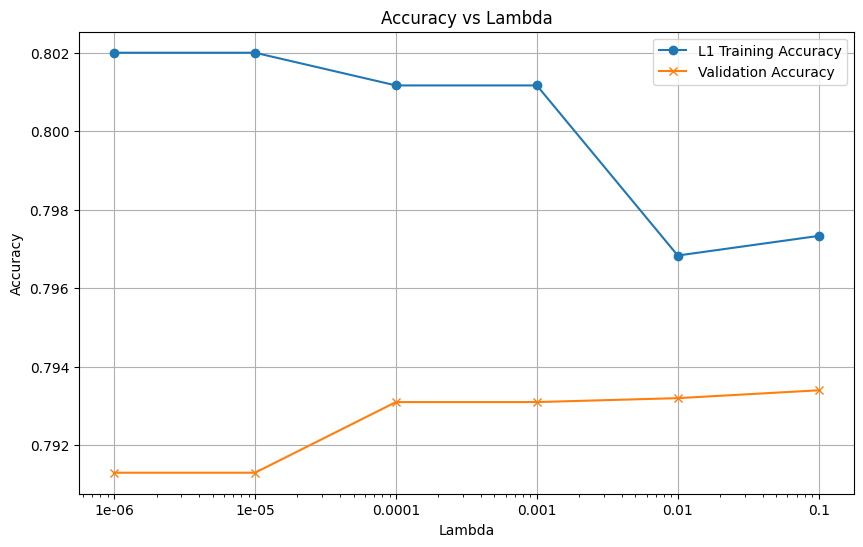

In [ ]:
# Your code goes here
print(trainl1_accuracies)
print(val_a)
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_val, trainl1_accuracies, label='L1 Training Accuracy', marker='o')
plt.semilogx(lambda_val, val_a, label='Validation Accuracy', marker='x')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda')
plt.legend()
plt.xticks(lambda_val, labels=[str(i) for i in lambda_val])
plt.grid(True)
plt.show()


**Question**

(a) Which $\lambda$ value leads to the best training and validatoin accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.

(c) What are some differences in the results between L1 and L2 regularized logistic regression? Which one achieved the best training accuracy? Which one achieved the best validation accuracy? Provide your own explanation for the observed differences.





**Your answer goes here** <br>

a) The $\lambda$ values that lead to the best training accuracy are  $10^{−6}$  and  $10^{−5}$ , while the best validation accuracy is seen at  0.1 . I would choose $\lambda$ equal to  0.1  during deployment since it has the greatest accuracy on unseen data which is more important in production.

b) When lambda is increasing, the training accuracy is decreasing. The validation accuracy starts lower at the smallest (${10^{-6}}$) lambda values, and then it increases after lambda greater than ${10^{-5}}$.

c) There is a small accuracy difference between L1 and L2 regression. However, L2's training and validation accuracy are a little bit higher than L1. And they have the same property: when the lambda increases, the training accuracy will decrease and the validation accuracy will increase.


###2.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [ ]:
#Your code goes here
top_features = {}

for lambda_reg in lambda_val:
    # Get the weights for the current λ sans bias
    w = wt[str(lambda_reg)][1:]

    top_feature_indices = np.argsort(np.abs(w))[::-1][:5]

    top_features[lambda_reg] = [(f"feature_{j}", w[j]) for j in top_feature_indices]

#DataFrame to display the results
df = pd.DataFrame(top_features)
df.index = ["1", "2", "3", "4", "5"]
df.columns.name = 'Rank'
df.index.name = 'λ'

#looks awful but easier to parse
#print(df)
display(df)

Rank,0.000001,0.000010,0.000100,0.001000,0.010000,0.100000
λ,,,,,,
1,"(feature_3, -3.2835077713977063)","(feature_3, -3.2835070225390592)","(feature_3, -3.2754141719467555)","(feature_3, -3.275404814609077)","(feature_3, -2.8944607592400464)","(feature_3, -2.897760488829747)"
2,"(feature_4, 2.3027896528270806)","(feature_4, 2.3027892612142087)","(feature_4, 2.2520500525740297)","(feature_4, 2.2520233260857485)","(feature_4, 2.2566096970353673)","(feature_4, 2.255878204134697)"
3,"(feature_76, -2.1290784435213834)","(feature_76, -2.129072614760798)","(feature_194, -1.8964999900018966)","(feature_194, -1.8965205558303173)","(feature_194, -1.3510909378669087)","(feature_194, -1.3560439156609334)"
4,"(feature_194, -1.8757840424842593)","(feature_194, -1.8757863788741247)","(feature_186, -0.9112368959356094)","(feature_186, -0.9112605097858486)","(feature_186, -0.77943182040521)","(feature_186, -0.7806766336891289)"
5,"(feature_74, 1.6211947114293073)","(feature_74, 1.6211797051439527)","(feature_10, 0.8850017487476635)","(feature_10, 0.8849441099519144)","(feature_61, -0.6260592292637182)","(feature_61, -0.6241429994311216)"


**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

1) When lambda increases, features 76, and 74 drop out from the top list, while features 186, and 61 emerge as more significant.

2) Yes, with higher regularization values there seems to be a general decrease in the largest weights. Feature 3 goes from having a weight of $-3.283$ to having a weight of $-2.89$. Other features see a simmilar decrease, and with higher regularizarion values, the top 5 go from having all 5 weights with a magnitude greater than 1 to just 3.

3) The observed differences in top features and their weights reflect the impact of L1 regularization on larger weights, pushing them to be smaller. The changes in top features suggest that regularization can shrink or amplify the impact of different features in the model.

4) The main difference is that L1 and L2 regularization select different features to become more prominent for some values of lambda. Eventually the same 5 features become the most prominent.


###2.3 Sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here
for lambda_reg in lambda_val:
    # Get the weights for the current λ
    w = wt[str(lambda_reg)]

    # Count the number of feature weights that are approximately equal to zero
    num_zero_weights = np.sum(np.abs(w[1:]) <= 1e-6)
    print(f"λ = {lambda_reg}: Sparsity = {num_zero_weights}")

λ = 1e-06: Sparsity = 47
λ = 1e-05: Sparsity = 47
λ = 0.0001: Sparsity = 47
λ = 0.001: Sparsity = 47
λ = 0.01: Sparsity = 48
λ = 0.1: Sparsity = 59


**Question**

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

1) As the $\lambda$ values used increase, the sparsity of the model increases. I expect that as $\lambda$ further increases that we would see this trend continue as the L1 regularization adds a penalty proportional to the absolute value of the coefficients. When increasing lamda, the penalty for having non-zero coefficients increase as well.

2) When comparing to the results from the L2 model, the L2 model seems consistent. The L2 model didn't get more
 sparse as the lamba value increased. This is likely becuase L2 regularization is penalizing the square of the weights and therefore putting proportionally less pressure on pushing already small weights to zero. For an example weight of 0.01, L1 regularization would impose a penality of 0.01 while L2 regularization would impose a penality of $(0.01)^2=0.0001$.

# Part 3. (25 pts) Impact of Noise
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data. For L2, you should consider the same set of $\lambda$ values as part 1. For L1, you will find it to be extremely difficult to converge to a meaningful solution for $\lambda=0.1$, so you will use the same set of values as part 2 but exclude $\lambda=0.1$.  For each regularization method, please plot the model's training and validation accuracy against the regularization parameter $\lambda$.

In [ ]:
# Your code goes here

# Calcualte l2 gradient and loss
def l2_regularization(lambda_reg, w):

  gradient_term     = (lambda_reg) * w                             # L2 Gradient Calcualtion
  loss_term         = (lambda_reg / 2) * np.sum(np.square(w[1:]))  # L2 Loss calculation
  gradient_term[0]  = 0                                            # Since w[0] is a bias not weight we assign the bias l2 gradient term to zero

  return gradient_term, loss_term                                  # Return L2 gradient and loss

def l1_regularization(lambda_reg, w):
  gradient_term    = lambda_reg * np.sign(w)                   # L1 Gradient calcualtion
  loss_term        = lambda_reg * np.sum(np.abs(w[1:]))        # L1 Loss calculation
  gradient_term[0] = 0                                         # Since w[0] is a bias not weight we assign the bias l1 gradient term to zero

  return gradient_term, loss_term                              # Return L1 gradient and loss

# Calcualte gradient with regularization and update weights
def apply_gradient_decent(X, Y, w, lr, reg_par, reg = 'L1'):
  m                      = X.shape[0]                          # Total number of training examples
  Z                      = np.dot(X, w)
  Y_pred                 = sigmoid(Z)

  # calculate gradient
  gradient_reg, loss_reg = l1_regularization(reg_par, w) if reg =='L1' else l2_regularization(reg_par, w)
  gradient               = (1 / m) * (np.dot(X.T, (Y_pred - Y)) + gradient_reg)

  # Update weight
  w -= lr * gradient

  # Loss calculation
  loss                   = (-1 / m) * (np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred)) + loss_reg)

  return w, gradient, loss

def calculate_acc(X, Y, w):
  Y_pred = (sigmoid(np.dot(X, w)) >= threshold).astype(np.int8)
  return np.mean((Y - Y_pred)==0.0)

def train_model(X, Y, lr, reg_par, reg = 'L2'):
  w = np.zeros((X.shape[-1], 1))
  losses = []
  acc_train = []
  acc_val   = []

  for epoch in range(num_iteration):
    w, gradient, loss = apply_gradient_decent(X, Y, w, lr, reg_par, reg)
    losses.append(loss)

      # print(f"Loss: {loss} | train_acc: {train_acc} | val_acc: {val_acc} ")

    if len(losses) > 2:
      if np.abs(losses[-1] - losses[-2]) < conv_thresh:
        print(f"Model converged at {epoch} iteration")
        train_acc = calculate_acc(X, Y, w)
        val_acc   = calculate_acc(X_validation, Y_validation, w)

        acc_train.append(train_acc)
        acc_val.append(val_acc)
        break

  return losses, acc_train, acc_val


In [ ]:
# Your code goes here

# Data Preprocessing
cols = [col for col in processed_train_data.columns if col != 'Response']

X_train      = processed_train_data[cols].values
X_validation = processed_val_data[cols].values
X_noisy      = processed_noisy_train[cols].values

#target vectors
Y_train      = processed_train_data['Response'].values[..., np.newaxis]
Y_validation = processed_val_data['Response'].values[..., np.newaxis]
Y_noisy      = processed_noisy_train['Response'].values[..., np.newaxis]

# Initiallize weights

num_iteration = 100000
conv_thresh   = 1e-7
threshold     = 0.5

In [ ]:
acc_train_all  = []
acc_val_all    = []
losses_all     = []

lambda_range   = [10**i for i in range(-5, 1)]

for lambda_reg in tqdm(lambda_range):
  if lambda_reg <= 1e-4:
    lr = 1.0
  elif lambda_reg <= 1e-3:
    lr = 0.1
  else:
    lr = 0.01
  losses, acc_train, acc_val = train_model(X_noisy, Y_noisy, lr, lambda_reg, reg = 'L2')
  acc_train_all.append(acc_train[-1])
  acc_val_all.append(acc_val[-1])

 17%|█▋        | 1/6 [00:48<04:04, 48.92s/it]

Model converged at 13729 iteration


 33%|███▎      | 2/6 [01:39<03:20, 50.19s/it]

Model converged at 13731 iteration


 50%|█████     | 3/6 [02:42<02:47, 55.76s/it]

Model converged at 17397 iteration


 67%|██████▋   | 4/6 [03:47<01:58, 59.34s/it]

Model converged at 18343 iteration


 83%|████████▎ | 5/6 [04:56<01:03, 63.00s/it]

Model converged at 18378 iteration


100%|██████████| 6/6 [06:04<00:00, 60.83s/it]

Model converged at 18710 iteration


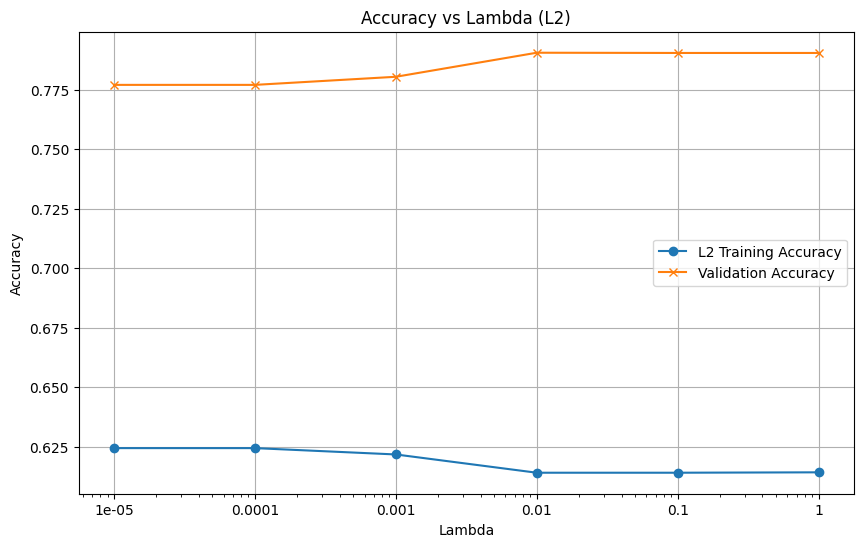

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_range, acc_train_all, label='L2 Training Accuracy', marker='o')
plt.semilogx(lambda_range, acc_val_all, label='Validation Accuracy', marker='x')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda (L2)')
plt.legend()
plt.xticks(lambda_range, labels=[str(i) for i in lambda_range])
plt.grid(True)
plt.show()

 17%|█▋        | 1/6 [00:52<04:24, 52.89s/it]

Model converged at 13729 iteration


 33%|███▎      | 2/6 [01:40<03:19, 49.93s/it]

Model converged at 13729 iteration


 50%|█████     | 3/6 [02:31<02:30, 50.22s/it]

Model converged at 13733 iteration


 67%|██████▋   | 4/6 [03:33<01:49, 54.93s/it]

Model converged at 17408 iteration


 83%|████████▎ | 5/6 [04:37<00:58, 58.36s/it]

Model converged at 18383 iteration


100%|██████████| 6/6 [05:45<00:00, 57.62s/it]

Model converged at 18722 iteration


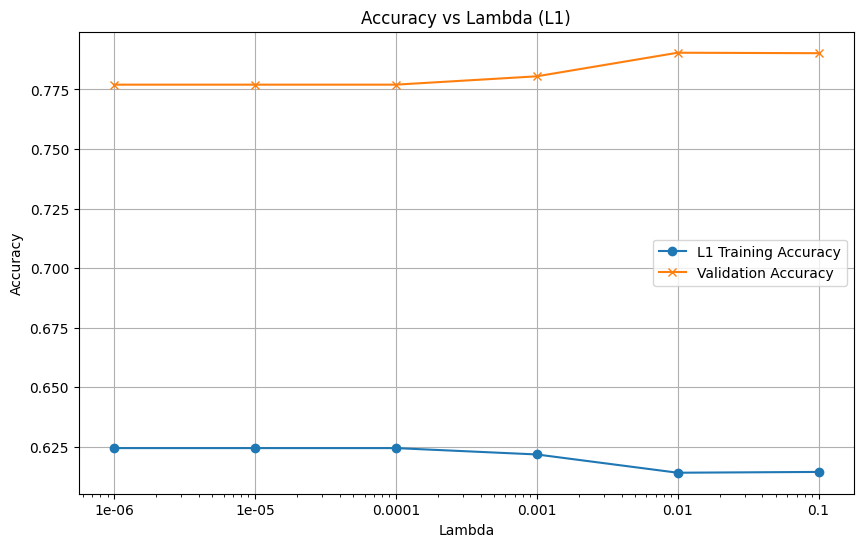

In [ ]:
acc_train_all  = []
acc_val_all    = []
losses_all     = []

lambda_range   = [10 ** i for i in range(-6, 0)]

for lambda_reg in tqdm(lambda_range):
  if lambda_reg <= 1e-4:
    lr = 1.0
  elif lambda_reg <= 1e-3:
    lr = 0.1
  else:
    lr = 0.01
  losses, acc_train, acc_val = train_model(X_noisy, Y_noisy, lr, lambda_reg, reg = 'L1')
  acc_train_all.append(acc_train[-1])
  acc_val_all.append(acc_val[-1])

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_range, acc_train_all, label='L1 Training Accuracy', marker='o')
plt.semilogx(lambda_range, acc_val_all, label='Validation Accuracy', marker='x')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda (L1)')
plt.legend()
plt.xticks(lambda_range, labels=[str(i) for i in lambda_range])
plt.grid(True)
plt.show()

**Question**
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression models would have substantially reduced training accuracies, but the validation accuracies will only suffer a mild reduction.  

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which reduces the model's ability to overfit to the noise.
2. This is due to the similicity of the model, which just could not overfit to the noise very well.

For this case, what do you think is the main cause for the observe phenomenon? Why?

Please design another experiment that will allow you to figure out which of the two possibilities plays a more critical role in the observed phenomenon. You do not have to run this experiment, but need to explain the experiment and why it would help.


**Your answer goes here.**

In the above experiment, we can clearly see that the training accuracy for both the L1 and L2 regularizations is below 63%, but the validation accuracy is around 78%. Therefore, there is a huge reduction in training accuracy while there is a small reduction in validation accuracy for both L1 and L2 regularization. Also, we can observe that there is very little or no effect of different lambdas on validation accuracy for both regularizations. So, it shows that regularization has little influence on the model.

We can do one more experiment to verify which phenonmenon either regularization or simplicity of the model

**Experiment:<br>**
Train three versions of logistic regression models on noisy data:

**L1 Regularized Logistic Regression:** As before, train a logistic regression model with L1 regularization.

**L2 Regularized Logistic Regression:** Train a logistic regression model with L2 regularization.

**Non-Regularized Logistic Regression:** Train a logistic regression model without any regularization.

Now, compare the training and validation accuracy of all three models. If regularization is the primary cause of the observed phenomenon, you would expect the non-regularized model to have a higher training accuracy (as it's more prone to overfitting the noise) and a lower validation accuracy (as it may generalize poorly), but for the L1 and L2 regularized models, it will have reduced training accuracy (which prevents overfitting) and relatively higher validation accuracy (increase generalization). This would support the hypothesis that **regularization** is responsible for the observed phenomenon.

However, if the non-regularized model has reduced training accuracy and relatively higher validation accuracy as a result of L1 and L2 regularization, then this would support the hypothesis that **model simplicity** plays a more critical role in the observed phenomenon.

